In [1]:
import commpy
import numpy as np
from __future__ import division

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Preliminaries

Remember the relation:

$$
\frac{C}{N} = \frac{E_b}{N_o} \cdot \frac{R}{B}
$$

See [here](http://www.eletrica.ufpr.br/evelio/TE111/Eb_N0.pdf).

$B$ is not the channel bandwidth; it's the receiver bandwidth. For NRZ encoding that's 0.5 of the bitrate. So usually $\frac{R}{B}$ is 2 (or 3 dB).

The AWGN simulator below is applied to the signal already on the channel, so it needs $C/N$, not $E_b/N_o$.

We want to simulate $\mathrm{BER}$ vs $E_b/N_o$.

So, for each $E_b/N_o$ value, first convert into $C/N$ before inputting it to the AWGN simulator.

#### Abstractions, abstractions, abstractions

In [3]:
chip_map = {}
with open('symbol_chip_mapping.txt', 'r') as f:
    for line in f:
        decimal, binary, chip = line.split()
        chip_map[int(decimal)] = np.array([int(x) for x in chip])

def spread(data_symbol):
    """
    data_symbol : int
    """
    return chip_map[data_symbol%16]

In [4]:
from ipyparallel import interactive

@interactive
class BaseEncoder(object):
    __name__ = 'encoder'
    def __init__(self):
        pass

@interactive
class NibbleEncoder(BaseEncoder):
    def encode(self, data):
        """
        data   : array of {0, 1, ..., N-1}^M
        return : ( list of (array of {0, 1}^(log2(N)) )^M
        """
        return map(lambda x: commpy.utilities.dec2bitarray(x, 4), data)
    
    def decode(self, data):
        """
        data   : ( list of (array of {0, 1}^(log2(N)) )^M
        return : array of {0, 1, ..., N-1}^M
        """
        return np.array(map(commpy.utilities.bitarray2dec, data))

@interactive
class ChipEncoder(BaseEncoder):
    def encode(self, data):
        return map(spread, data)
    
    def decode(self, data):
        return np.array([np.argmax([np.correlate(y, x) for x in chip_map.itervalues()]) for y in data])

In [5]:
@interactive
class BaseModem(object):
    __name__ = 'modem'

@interactive
class QPSK(BaseModem):
    def __init__(self):
        self.modem = commpy.modulation.PSKModem(4)
    
    def modulate(self, bits):
        """
        bits   : ( list of (array of {0, 1}^(log2(N)) )^M
        return : ( list of (array of complex^(log2(N)/2)) )^M
        """
        return map(self.modem.modulate, bits)
    
    def demodulate(self, symbols):
        """
        symbols : ( list of (array of complex^(log2(N)/2)) )^M
        return  : ( list of (array of {0, 1}^(log2(N)) )^M
        """
        return map(lambda x: self.modem.demodulate(x, 'hard'), symbols)

In [6]:
def awgn(symbols, snr):
    """
    symbols : ( list of (array of complex^(log2(N)/2)) )^M
    snr     : number
    return  : same type and shape as symbols
    """
    return map(lambda x: commpy.channels.awgn(x, snr, rate=1), symbols)

def rayleigh(symbols, params):
    pass

In [7]:
# the function to be run in parallel
def compute_ber(encoder, modem, channel, snr):
    nerr = 0
    for rep in range(100):
        in_data = np.random.randint(0, 16, 10000)

        # tx
        in_bits = encoder.encode(in_data)
        in_symbols = modem.modulate(in_bits)

        # channel
        out_symbols = channel(in_symbols, snr)

        # rx
        out_bits = modem.demodulate(out_symbols)
        out_data = encoder.decode(out_bits)
        
        nerr += (in_data != out_data).sum()
        
    return nerr / (100 * len(in_data))

#### Setup multiple cores

In [8]:
# run `ipcluster start`
from ipyparallel import Client

c = Client()
dview = c[:]
dview.execute('import numpy as np; import commpy')
dview.use_dill()

<AsyncResult: finished>

In [9]:
def __push_vars(view, *args):
    for arg in args:
        view[arg.__name__] = arg

## QPSK

#### Theory

QPSK over AWGN curve:

$$
\mathrm{BER} = \frac{1}{2}\mathrm{erfc}\sqrt{E_b/N_o}
$$

[wikipedia](https://en.wikipedia.org/wiki/Bit_error_rate)

In [10]:
from scipy.special import erfc

In [11]:
ebno = np.arange(-3, 8)
ebno

array([-3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7])

In [12]:
def db20_to_linear(x):
    return 10 ** (x / 20)

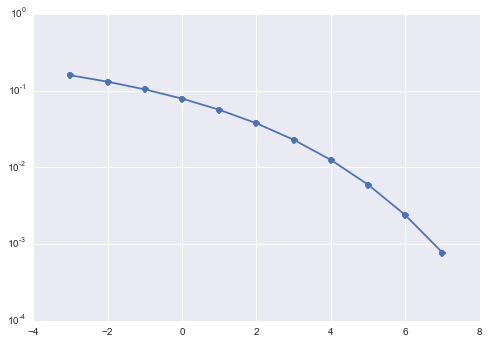

In [13]:
th_ber = 0.5 * erfc(db20_to_linear(ebno))
plt.plot(ebno, th_ber, '-o')
plt.yscale('log')

In [14]:
snr = ebno + 3
snr

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

#### Simulation

In [15]:
encoder = NibbleEncoder()
modem = QPSK()

__push_vars(dview, compute_ber, encoder, modem, awgn)
res = dview.map(lambda x: compute_ber(encoder, modem, awgn, x), snr)
res

<AsyncMapResult: <lambda>>

In [16]:
ber = res.get()

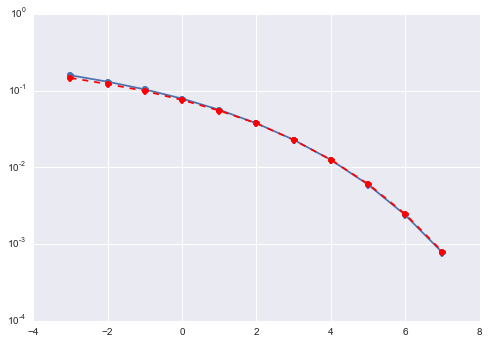

In [17]:
plt.plot(ebno, th_ber, '-o')
plt.plot(ebno, ber, 'r--o')
plt.yscale('log')

## QPSK with 802.15.4 DSSS

In [18]:
low_ebno = np.arange(-80, -30, 10)
low_snr = low_ebno + 3
low_snr

array([-77, -67, -57, -47, -37])

In [28]:
cencoder = ChipEncoder()

#__push_vars(dview, cencoder, spread)
dview['cencoder'] = cencoder
dview['chip_map'] = chip_map
res = dview.map(lambda x: compute_ber(cencoder, modem, awgn, x), low_snr)
res

<AsyncMapResult: <lambda>>

In [29]:
low_ber = res.get()
low_ber

[0.0, 0.0, 0.0, 0.0, 0.0]

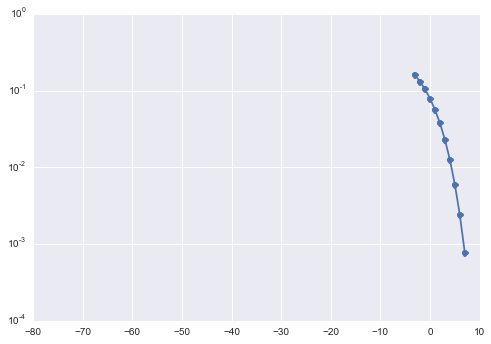

In [30]:
plt.plot(ebno, th_ber, '-o')
plt.plot(low_ebno, low_ber, 'r--o')
plt.yscale('log')